# Attempt to Model Velocity Dependence
Attempt to model the change in stopping force as a function of velocity

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import os

## Load in Data
Read in data from all velocities, and a new featurizer

In [2]:
data = pd.read_pickle(os.path.join('..', 'training_data.pkl.gz'))

In [3]:
with open('featurizer.pkl', 'rb') as fp:
    featurizer = pkl.load(fp)

In [4]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

## Separate Channel and Random Trajectories
Let's train first on the random trajectories as a starting point

In [5]:
channel_data = data[data['directory'].str.contains('datasets/Al_256_channel')]

Get the random trajecotries

In [6]:
data = data[data['directory'].str.contains('datasets/256_Al')]
print('Selected {} training entries'.format(len(data)))

Selected 48069 training entries


## Determine the "start" value
Determine the point at which the effect of adding the particle has gone away

Text(0, 0.5, 'Force')

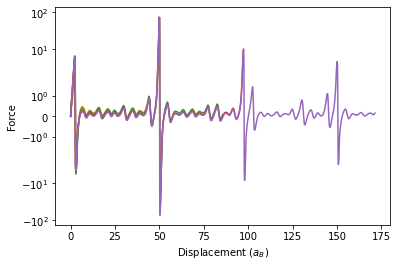

In [7]:
fig, ax = plt.subplots()

plot_max = 3000
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid)

#ax.legend(ncol=2)
ax.set_yscale('symlog')
    
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

Text(0, 0.5, 'Force')

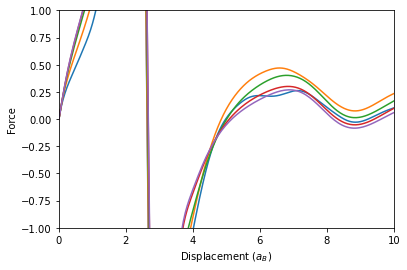

In [8]:
fig, ax = plt.subplots()

plot_max = -1
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.set_xlim(0, 10)

ax.set_ylim(-1, 1)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

Andre uses 6 $a_B$

In [9]:
data.query('displacement >= 6', inplace=True)

## Generate Features
Use the same features at the Al model

In [10]:
X_cols = featurizer.feature_labels()
y_col = 'force'

## Mark the Average Range on the Channel Dataset
Let's average the 2nd and third repeats

In [11]:
lat_spacing = start_frame.cell[0,0] / 4

In [12]:
channel_data['average_range'] = np.logical_and(channel_data['displacement'] > lat_spacing, channel_data['displacement'] <= lat_spacing * 3)

## Fit on Entire Dataset
Use the Bayesian Ridge Regression model from previous examples. 

In [13]:
model = pkl.load(open(os.path.join('..', 'single-velocity', 'best_model.pkl'), 'rb'))

In [14]:
model.param_grid = {'lasso_rfe__estimator__max_iter': range(40, 80, 2)}

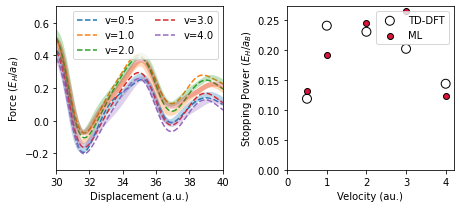

In [15]:
model.fit(data[X_cols], data[y_col])
data['force_fit'] = model.predict(data[X_cols])

fig, ax = plt.subplots(1, 2)

velocity = []
stopping_pred = []
stopping_actual = []
for gid, group in data.groupby('directory'):
    velocity.append(float(gid[-3:]))

    # Plot the performance
    my_line, = ax[0].plot(group['displacement'], group['force'], linestyle='--', label='v='+gid[-3:])

    ax[0].plot(group['displacement'], model.predict(group[X_cols]), color=my_line.get_color(), lw=5, alpha=0.3)

    ax[0].set_xlim(30, 40)
    ax[0].set_ylim(-0.3, 0.7)
    ax[0].legend(ncol=2)

    ax[0].set_xlabel('Displacement (a.u.)')
    ax[0].set_ylabel('Force ($E_H / a_B$)')

    # Plot the mean velocity
    stopping_pred.append(group['force_fit'].mean())
    stopping_actual.append(group['force'].mean())

# Plot the stopping power
ax[1].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
ax[1].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')

ax[1].set_ylabel('Stopping Power ($E_H / a_B$)')
ax[1].set_xlabel('Velocity (au.)')
ax[1].set_ylim(0, max(ax[1].get_ylim()))
ax[1].set_xlim(0, 4.2)
ax[1].legend()

fig.set_size_inches(6.5, 3)
fig.tight_layout()

In [16]:
stopping_mape = np.abs(np.subtract(stopping_actual, stopping_pred) / stopping_actual).mean()
print(f'Mean percent error: {stopping_mape * 100:.2f}%')

Mean percent error: 16.57%


The model fails to capture the trends in stopping power with velocity. We might just need more complexity

## Save Data
Save the training set used by this model

In [17]:
data.to_pickle(os.path.join('data', 'random_traj.pkl'))

In [18]:
channel_data.to_pickle(os.path.join('data', 'channel_traj.pkl'))